In [229]:
import qiskit
from qiskit.quantum_info import state_fidelity
import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy

I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Random unitary generator
def random_unitary(n):
    A = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    Q, _ = np.linalg.qr(A)
    return Q


def random_anti_herm(n):
    A = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    return A - A.conj().T

L = 4
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
#hamil = qib.IsingHamiltonian(field, 1, 0, 0).as_matrix().toarray()
hamil = qib.HeisenbergHamiltonian(field, (1,1,1), (0,0,0)).as_matrix().toarray()
nlayers = 3
perms = [[i for i in range(L)] if i%2==0 else [i for i in range(1, L)]+[0] for i in range(nlayers)]
#perms = [[i for i in range(L)], [i for i in range(1, L)]+[0]]

t = 1
U = scipy.linalg.expm(-1j*t*hamil)
U_back = scipy.linalg.expm(1j*t*hamil)
cU = U_back

In [230]:
import sys
sys.path.append("../ccU_dagger")
from ansatz_dagger import ansatz_dagger

I2 = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])


G1 = np.kron(I2, Z)
G2 = np.kron(I2, I2)
G3 = np.kron(I2, I2)
Glist_opt = [G1, G2, G2]

np.linalg.norm(cU - ansatz_dagger(Glist_opt, U, L, perms), ord=2)

1.888208301055137

In [231]:
from optimize_dagger import err_dagger as err
from ansatz_dagger import ansatz_grad_vector_dagger
from utils_dagger import antisymm_to_real, antisymm, partial_trace_keep

f = err

# Function to compute analytical gradient
def grad_analytical(Glist, U, cU, L, perms, flatten=True):
    return -ansatz_grad_vector_dagger(Glist, cU, U, L, perms, flatten=flatten)


def grad_numerical(Glist, U, cU, epsilon=1e-6, flatten=True):
    grads = []
    for _ in range(len(Glist)):
        W = Glist[_]
        d = Glist[_].shape[0]
        grad_complex = np.zeros((d, d), dtype=complex)

        for i in range(d):
            for j in range(d):
                # Real perturbation
                dW_real = np.zeros_like(W, dtype=complex)
                dW_real[i, j] = epsilon

                Glist_plus_real  = Glist[:_] + [W + dW_real] + Glist[_+1:]
                Glist_minus_real = Glist[:_] + [W - dW_real] + Glist[_+1:]
                
                f_plus  = f(Glist_plus_real, U, L, perms, cU)
                f_minus = f(Glist_minus_real, U, L, perms, cU)
                df_real = (f_plus - f_minus) / (2 * epsilon)

                # Imaginary perturbation
                dW_imag = np.zeros_like(W, dtype=complex)
                dW_imag[i, j] = 1j * epsilon

                Glist_plus_imag  = Glist[:_] + [W + dW_imag] + Glist[_+1:]
                Glist_minus_imag = Glist[:_] + [W - dW_imag] + Glist[_+1:]
                
                f_plus  = f(Glist_plus_imag, U, L, perms, cU)
                f_minus = f(Glist_minus_imag, U, L, perms, cU)
                df_imag = (f_plus - f_minus) / (2 * epsilon)
    
                grad_complex[i, j] = df_real + 1j * df_imag
        grads.append(grad_complex)
    
    stack = np.stack([ antisymm_to_real(antisymm(W.conj().T @ grads[j])) for j, W in enumerate(Glist)])
    if flatten:
        return stack.reshape(-1)
    return stack

# Compute gradients
Glist = [random_unitary(4) for i in range(len(perms))]
grad_a = grad_analytical(Glist, U, cU, L, perms, flatten=True)
grad_n = grad_numerical(Glist, U, cU, flatten=True)

# Compare
error = np.linalg.norm(grad_a - grad_n)
print("Difference (Frobenius norm):", error)

Difference (Frobenius norm): 2.5745018690522107e-09


In [232]:
# Numerical Test function for: d/G_j d/dG_i f(G)
import sys
sys.path.append("../ccU_dagger")
from utils_dagger import polar_decomp, project_unitary_tangent, real_to_antisymm, antisymm_to_real, antisymm
from hessian_dagger import ansatz_hessian_matrix_dagger
from ansatz_dagger import ansatz_grad_vector_dagger


def numerical_hessian(Glist, cU, U, L, perms, i, j, epsilon=1e-6):
    """Numerically compute d/dW1 of projected gradient dL/dV1 (Riemannian)."""
    numerical_H = []

    for _ in range(16):
        Z_real = np.zeros(16)
        Z_real[_] = 1.0
        Z = real_to_antisymm(Z_real.reshape(4, 4))  # 4x4 anti-Hermitian direction

        Gj_plus  = Glist[j] @ scipy.linalg.expm(+epsilon*Z)
        Gj_minus = Glist[j] @ scipy.linalg.expm(-epsilon*Z)


        if i==j:
            grad_plus  = ansatz_grad_vector_dagger(Glist[:j]+[Gj_plus]+Glist[j+1:], cU, U, L, perms, unprojected=True, flatten=False)[i]
            grad_minus = ansatz_grad_vector_dagger(Glist[:j]+[Gj_minus]+Glist[j+1:], cU, U, L, perms, unprojected=True, flatten=False)[i]
            dgrad = (grad_plus - grad_minus) / (2 * epsilon)  # shape (16,)
            G = dgrad.reshape(4, 4)

            V = Glist[j]
            Z = V @ Z
            G = project_unitary_tangent(V, G)
            grad = ansatz_grad_vector_dagger(Glist, cU, U, L, perms, flatten=False, unprojected=True)[i]
            
            G -= 0.5 * (Z @ grad.conj().T @ V + V @ grad.conj().T @ Z)
            if not np.allclose(Z, project_unitary_tangent(V, Z)):
                G -= 0.5 * (Z @ V.conj().T + V @ Z.conj().T) @ grad
            G = antisymm_to_real(antisymm( V.conj().T @ G ))
        else:
            grad_plus  = ansatz_grad_vector_dagger(Glist[:j]+[Gj_plus]+Glist[j+1:], cU, U, L, perms, unprojected=False, flatten=False)[i]
            grad_minus = ansatz_grad_vector_dagger(Glist[:j]+[Gj_minus]+Glist[j+1:], cU, U, L, perms, unprojected=False, flatten=False)[i]
            dgrad = (grad_plus - grad_minus) / (2 * epsilon)  # shape (16,)
            G = dgrad.reshape(4, 4)

            
        numerical_H.append(G)
    
    return np.array(numerical_H)  # shape: (16, 4, 4)


i, j = 0,0
Glist = [random_unitary(4) for _ in range(len(perms))]
H = ansatz_hessian_matrix_dagger(Glist, cU, U, L, perms, unprojected=False, flatten=False)
grad = []
for _ in range(16):
    grad.append(H[i, :, j, _].reshape(4,4))
analytical = np.array(grad)

numerical = numerical_hessian(Glist, cU, U, L, perms, i, j)  

print("Difference norm:", np.linalg.norm(numerical - analytical))

Difference norm: 3.1899243309048373e-09


In [233]:
sys.path.append("../ccU")
from utils import applyG_block


def bootstrap_U(Glist, U, perms):    
    Vlist = Glist
    Wlist = [G.conj().T for G in Glist[::-1]]

    V = applyG_block(Vlist[0], L, perms[0])
    for i in range(1, len(perms)):
        V = applyG_block(Vlist[i], L, perms[i]) @ V

    W = applyG_block(Wlist[0], L, perms[0])
    for i in range(1, len(perms)):
        W = applyG_block(Wlist[i], L, perms[i]) @ W

    return W@U@V, V, W

In [236]:
import sys
sys.path.append("../ccU_dagger")
from optimize_dagger import optimize_circuit_dagger, err_dagger
from ansatz_dagger import ansatz_dagger

sys.path.append("../ccU")
from utils import applyG_block


Glists = []
f_iters = []
err_iters = []
for _ in range(10):
    Glist_start = [random_unitary(4) for _ in range(len(perms))]
    
    Glist, f_iter, err_iter = optimize_circuit_dagger(L, U, cU, Glist_start, perms, niter=30)
    
    print("Best f: ", f_iter[-1])
    print("Best err: ", err_iter[-1])

    Glists.append(Glist)
    f_iters.append(f_iter)
    err_iters.append(err_iter)

Best f:  -11.89222400668186
Best err:  1.8100376584955196
Best f:  -11.834416157831686
Best err:  1.8253223490935668
Best f:  -11.928867179069876
Best err:  1.709527757790646
Best f:  -12.049548428129828
Best err:  1.7108166914777863
Best f:  -11.980830640349454
Best err:  1.677722745100316
Best f:  -12.087462896291663
Best err:  1.6376091562364938
Best f:  -11.769260480154996
Best err:  1.8268588417965563
Best f:  -11.738483233391577
Best err:  1.8693882950559635
Best f:  -11.864158366495865
Best err:  1.8298201114392665
Best f:  -12.076024058845501
Best err:  1.6501945478027567


In [ ]:
t = 1
U = scipy.linalg.expm(-1j*t*hamil)
U_back = scipy.linalg.expm(1j*t*hamil)
cU = U_back

np.linalg.norm(ansatz_dagger(Glist, U, L, perms) - cU, ord=2)

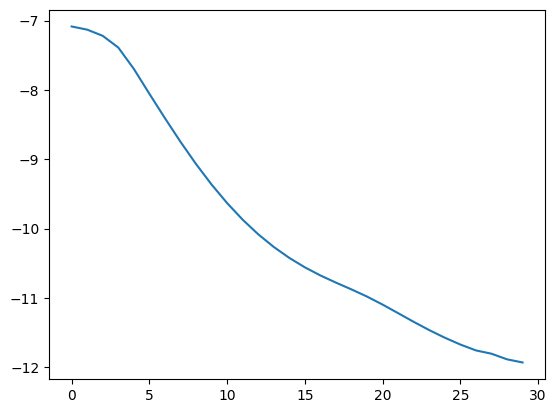

In [237]:
plt.plot(f_iters[2])